In [9]:
using PyPlot

In [25]:
# discretization
t = Array(2020:1.:2100);

# CO2 concentration (ppm) at t[1]
c_00 = 415.;

# physical climate parameters
ECS = 3.; # Equilibrium Climate Sensitivity
ϵ = ECS/log(2.); # Transient Warming Parameter
δT_00 = 1.1; # Warming at t[1] since preindustrial

# baseline emissions scenarios
q = 5. .* ones(size(t)); # emissions scenario
q[40:81] .= q[1] * (40. .-(0.:1.:41.))/40.
q[81:end] .= 0.
c_0 = c_00 .+ cumsum(q); # cumulative CO2 concentrations (ppm)
δT_0 = δT_00 .+ ϵ.*log.(c_0/c_00); # warming due to baseline emissions scenario

# economic parameters
β = 1.; # damage parameter (10^12 $ / C^2)
D_0 = β .* δT_0.^2; # baseline damages (10^12 $)
ρ = 0.02 # utility discount rate

GWP = 100. # Global World Product (10^12 $/yr)
C_ϕ = 0.05*GWP; # carbon removal (10^12 $/yr)
C_φ = 0.05*GWP; # emissions reductions (10^12 $/yr)
C_χ = 0.1*GWP; # adaptation (10^12 $/yr)
C_λ = 0.15*GWP; # geoengineering (10^12 $/yr)

f_low(α::Array) = (α ./ (1. .+ α)).^2 # shape of individual cost functions
f_med(α::Array) = α.^2 # shape of individual cost functions
f_high(α::Array) = (α ./ (1. .- α)).^2 # shape of individual cost functions

# Example control trajectories
# (picked because cost of controls + cost of controlled damage < uncontrolled damage)
nondim_linear(t::Array) = (t .- t[1])/(t[end] - t[1]);
ϕ = nondim_linear(t); # carbon removal
ϕ[t.>2100] .= ϕ[t.==2100]
φ = nondim_linear(t)/3.; # emissions reductions
χ = nondim_linear(t)/8.; # adaptation
λ = nondim_linear(t)/10.; # geoengineering

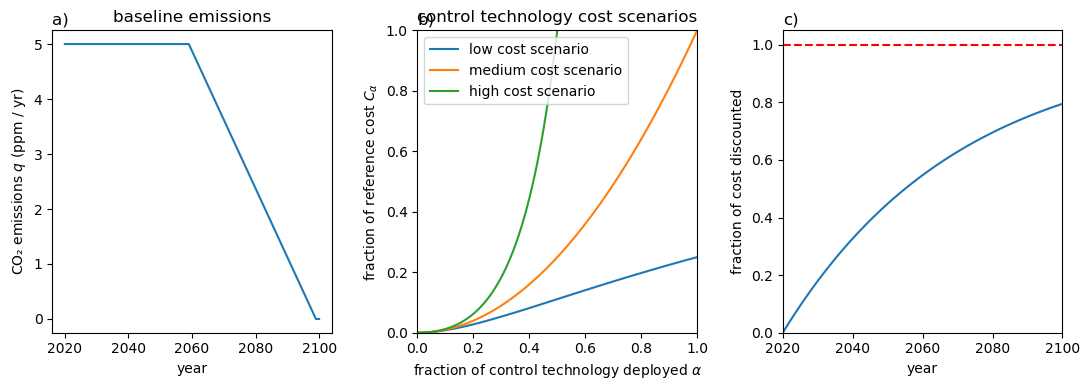

In [26]:
x = 0:0.01:1.

y_low = (x./(1. .+x)).^2
y_med = x.^2
y_high = (x./(1. .-x)).^2

figure(figsize=(11,4))
subplot(1,3,1)
plot(t,q)
ylabel(L"CO₂ emissions $q$ (ppm / yr)")
xlabel("year")
title("baseline emissions")
annotate(s="a)",xy=(0,1.02),xycoords="axes fraction",fontsize=12)

subplot(1,3,2)
plot(x,y_low, label="low cost scenario")
plot(x,y_med, label="medium cost scenario")
plot(x,y_high, label="high cost scenario")
xlim([0,1])
ylim([0,1])
title("control technology cost scenarios")
ylabel(L"fraction of reference cost $C_{\alpha}$")
xlabel(L"fraction of control technology deployed $\alpha$")
legend()
annotate(s="b)",xy=(0,1.02),xycoords="axes fraction",fontsize=12)


subplot(1,3,3)
discounting = (1. / (1. + ρ)).^(t.-t[1])
plot(t,1. .-discounting)
plot(t, ones(size(t)), "r--")
xlabel("year")
ylabel("fraction of cost discounted")
xlim(t[1],t[end])
ylim(0,1.05)
annotate(s="c)",xy=(0,1.02),xycoords="axes fraction",fontsize=12)

tight_layout()

savefig("figures/model_configuration.png", bbox_inches="tight", dpi=100)

In [27]:
c(ϕ::Array, φ::Array) = c_0 .- cumsum(q .* φ) .- cumsum(q[1] .* ϕ);
δT(ϕ::Array, φ::Array) = δT_00 .+ ϵ.*log.(c(ϕ,φ)./c_00);

D(ϕ::Array, φ::Array, χ::Array, λ::Array) = (1. .- χ) .* β .* δT(ϕ, φ).^2 .* (1. .- λ).^2;

C(ϕ::Array, φ::Array, χ::Array, λ::Array) = C_λ.*f_med(λ) .+ C_ϕ.*f_med(ϕ) .+ C_φ.*f_med(φ) .+ C_χ.*f_med(χ);
T(ϕ::Array, φ::Array, χ::Array, λ::Array) = (
    sum((C(ϕ, φ, χ, λ) .+ D(ϕ, φ, χ, λ)) .* (1. / (1. + ρ)).^(t.-t[1])) .+
    200. * (sum(diff(ϕ).^2) .+ sum(diff(φ).^2) .+ sum(diff(χ).^2) .+ sum(diff(λ).^2)) .+
    200. .* (ϕ[1].^2 .+ φ[1].^2 .+ χ[1].^2 .+ λ[1].^2)
);

# Emissions, concentrations, warming, and cost trajectories for initial guess scenario

Assuming medium cost scenario $f_{\text{med}}(\alpha) = \alpha^{2}$.

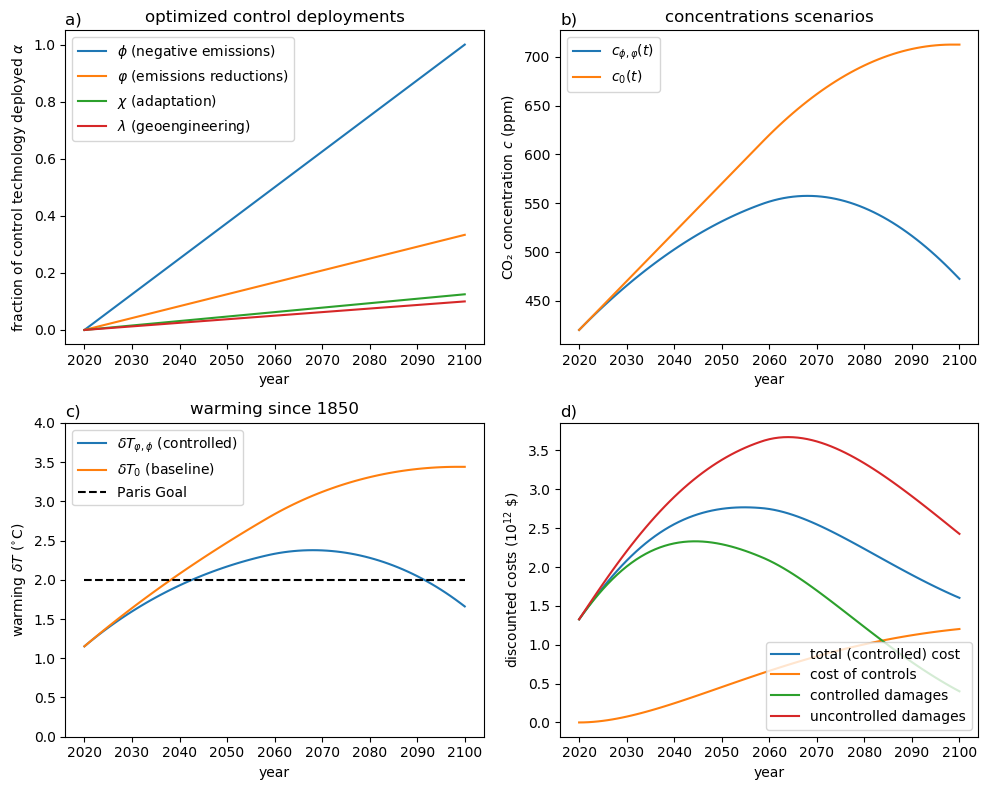

In [28]:
figure(figsize=(10,8))
subplot(2,2,1)
plot(t, ϕ, label=L"$\phi$ (negative emissions)")
plot(t, φ, label=L"$\varphi$ (emissions reductions)")
plot(t, χ, label=L"$\chi$ (adaptation)")
plot(t, λ, label=L"$\lambda$ (geoengineering)")
ylabel(L"fraction of control technology deployed $\alpha$")
xlabel("year")
title("optimized control deployments")
legend()
annotate(s="a)",xy=(0,1.02),xycoords="axes fraction",fontsize=12)


subplot(2,2,2)
plot(t,c(ϕ,φ), label=L"$c_{\phi,\varphi}(t)$")
plot(t,c_0, label=L"$c_{0}(t)$")
legend()
ylabel(L"CO₂ concentration $c$ (ppm)")
xlabel("year")
title("concentrations scenarios")
annotate(s="b)",xy=(0,1.02),xycoords="axes fraction",fontsize=12)

subplot(2,2,3)
plot(t,δT(ϕ, φ), label=L"$\delta T_{\varphi,\phi}$ (controlled)")
plot(t,δT_0, label=L"$\delta T_{0}$ (baseline)")
plot(t,2.0.*ones(size(t)),"k--", label="Paris Goal")
ylabel(L"warming $δT$ ($^{\circ}$C)")
xlabel("year")
ylim([0,4.0])
legend()
title("warming since 1850")
annotate(s="c)",xy=(0,1.02),xycoords="axes fraction",fontsize=12)

subplot(2,2,4)
plot(t, (C(ϕ, φ, χ, λ) + D(ϕ, φ, χ, λ)) .* discounting, label="total (controlled) cost")
plot(t, C(ϕ, φ, χ, λ) .* discounting, label="cost of controls")
plot(t, D(ϕ, φ, χ, λ) .* discounting, label="controlled damages")
plot(t, D_0 .* discounting, label="uncontrolled damages")
ylabel(L"discounted costs (10$^{12}$ \$)")
xlabel("year")
legend()
annotate(s="d)",xy=(0,1.02),xycoords="axes fraction",fontsize=12)

tight_layout()


savefig("figures/model_trajectories_initial_guess.png", bbox_inches="tight", dpi=100)

## Gradient descent cost minimization

This currently uses a very crude optimization method, gradient descent with momentum (see for example https://ruder.io/optimizing-gradient-descent/), with constraints of continuity and zero-controls at 2020 imposed as ad-hoc cost terms.

In [29]:
function ∇T(ϕ::Array, φ::Array, χ::Array, λ::Array)
    Δα = 1.e-5
    ∂T∂ϕ = zeros(size(ϕ))
    ∂T∂φ = zeros(size(φ))
    ∂T∂χ = zeros(size(χ))
    ∂T∂λ = zeros(size(λ))
    for i=1:length(ϕ)
        δα = zeros(size(ϕ))
        δα[i] = Δα
        ∂T∂ϕ[i] = (T(ϕ.+δα,φ,χ,λ) .- T(ϕ,φ,χ,λ))/Δα
        ∂T∂φ[i] = (T(ϕ,φ.+δα,χ,λ) .- T(ϕ,φ,χ,λ))/Δα
        ∂T∂χ[i] = (T(ϕ,φ,χ.+δα,λ) .- T(ϕ,φ,χ,λ))/Δα
        ∂T∂λ[i] = (T(ϕ,φ,χ,λ.+δα) .- T(ϕ,φ,χ,λ))/Δα
    end
    
    return (∂T∂ϕ, ∂T∂φ, ∂T∂χ, ∂T∂λ)
end

function convergence(∇T, tol = 1.e-6)
    norm = 0.
    for ∂T∂α = ∇T
        norm += sum(∂T∂α.^2)
    end
    return norm < tol
end

convergence (generic function with 2 methods)

In [30]:
count = 1
vprevious = [0., 0., 0., 0.]
while convergence(∇T(ϕ, φ, χ, λ), 1.e-8) == false
    ∇ = ∇T(ϕ, φ, χ, λ)
    norm = 0.
    for ∂T∂α = ∇
        norm += sum(∂T∂α.^2)
    end
    print(norm, " ")
    Δs = 5.e-4 # learning rate
    γ = 0.9 # momentum fraction
    v = [∇[1].*Δs .+ γ*vprevious[1],
         ∇[2].*Δs .+ γ*vprevious[2],
         ∇[3].*Δs .+ γ*vprevious[3],
         ∇[4].*Δs .+ γ*vprevious[4]]
    ϕ .-= v[1]
    φ .-= v[2]
    χ .-= v[3]
    λ .-= v[4]
    count+=1
    
    vprevious = copy(v)
    
    if count>1000
        break
    end
end

2070.2502790958592 1939.1597084542866 1784.834270939937 1643.3460935774497 1482.2244020551866 1301.7312997917293 1129.3353439172117 969.7558330137014 818.72189656618 683.7797077482498 569.4301603044267 472.0457709855971 391.1898452169305 327.92412494741967 279.1724149497028 242.04913420565694 215.72281332796697 197.99041075146215 186.10267553983712 178.83236450696302 174.95377475262774 172.72213910785126 171.23866178194453 170.06625490065363 168.44937739556076 165.96248418968912 162.64224292729682 158.3814959034708 153.10158569010426 147.0258123464968 140.33938655520228 133.12711719734384 125.61040248503177 118.02111354331205 110.46944103083261 103.09040081635722 96.04384926996842 89.39772531213873 83.19171927676365 77.48903397095233 72.30353120504482 67.60930120521253 63.39770707935219 59.6459617512119 56.30087851626439 53.32003342155567 50.667513220078035 48.29131295353828 46.14452996346043 44.19415861659232 42.40304927837697 40.73612462133357 39.172114777720026 37.69246012426231 36.

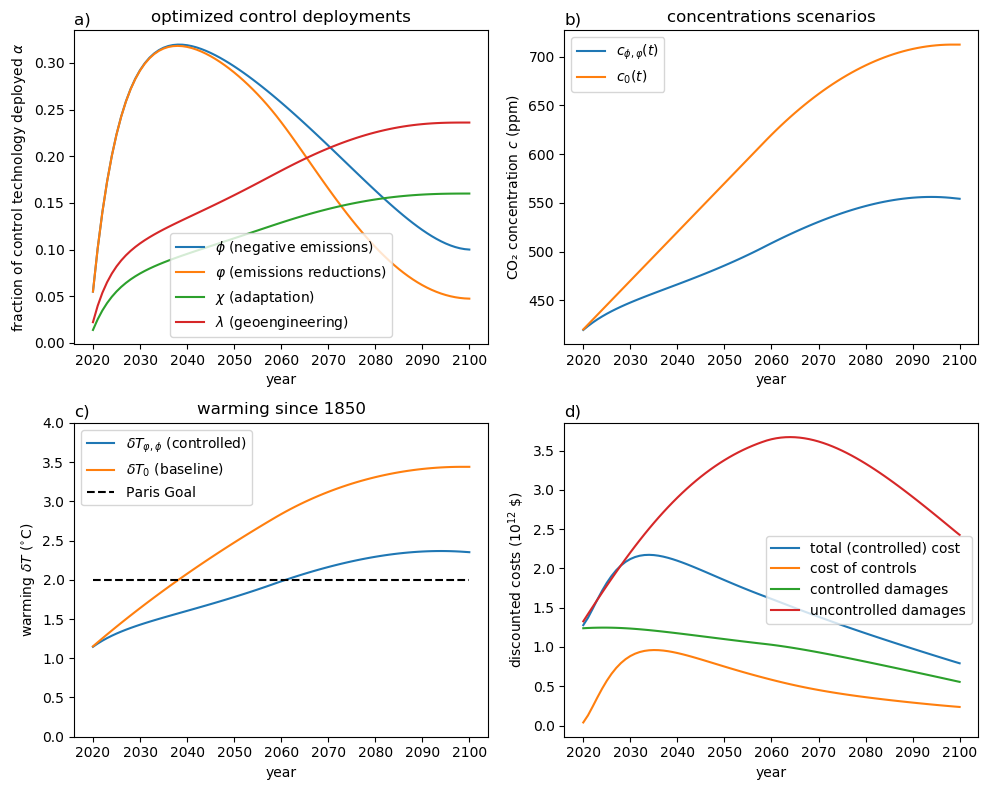

In [31]:
figure(figsize=(10,8))
subplot(2,2,1)
plot(t, ϕ, label=L"$\phi$ (negative emissions)")
plot(t, φ, label=L"$\varphi$ (emissions reductions)")
plot(t, χ, label=L"$\chi$ (adaptation)")
plot(t, λ, label=L"$\lambda$ (geoengineering)")
ylabel(L"fraction of control technology deployed $\alpha$")
xlabel("year")
title("optimized control deployments")
legend()
annotate(s="a)",xy=(0,1.02),xycoords="axes fraction",fontsize=12)


subplot(2,2,2)
plot(t,c(ϕ,φ), label=L"$c_{\phi,\varphi}(t)$")
plot(t,c_0, label=L"$c_{0}(t)$")
legend()
ylabel(L"CO₂ concentration $c$ (ppm)")
xlabel("year")
title("concentrations scenarios")
annotate(s="b)",xy=(0,1.02),xycoords="axes fraction",fontsize=12)

subplot(2,2,3)
plot(t,δT(ϕ, φ), label=L"$\delta T_{\varphi,\phi}$ (controlled)")
plot(t,δT_0, label=L"$\delta T_{0}$ (baseline)")
plot(t,2.0.*ones(size(t)),"k--", label="Paris Goal")
ylabel(L"warming $δT$ ($^{\circ}$C)")
xlabel("year")
ylim([0,4.0])
legend()
title("warming since 1850")
annotate(s="c)",xy=(0,1.02),xycoords="axes fraction",fontsize=12)

subplot(2,2,4)
plot(t, (C(ϕ, φ, χ, λ) + D(ϕ, φ, χ, λ)) .* discounting, label="total (controlled) cost")
plot(t, C(ϕ, φ, χ, λ) .* discounting, label="cost of controls")
plot(t, D(ϕ, φ, χ, λ) .* discounting, label="controlled damages")
plot(t, D_0 .* discounting, label="uncontrolled damages")
ylabel(L"discounted costs (10$^{12}$ \$)")
xlabel("year")
legend()
annotate(s="d)",xy=(0,1.02),xycoords="axes fraction",fontsize=12)

tight_layout()

savefig("figures/model_trajectories_optimized.png", bbox_inches="tight", dpi=100)